# Implementación Trabajo Lógica Difusa

Autor: Ignacio Fernández Sánchez-Pascuala

### Preprocesamiento de datos

In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.model_selection import train_test_split

In [50]:
# Lee el archivo CSV en un DataFrame de Pandas
df = pd.read_csv('Aero41-Mayo-2022.csv',parse_dates=['Date'])

# Selecciona las columnas requeridas
df_filtered = df[['Date', 'AmbTemp_Avg', 'WindSpeed_Avg', 'Power_Avg','Disponibilidad']]

# Aplica la condición y asigna los valores adecuados
df_filtered.loc[df_filtered['Power_Avg'] < 0, 'Power_Avg'] = 0

# Ordenar el DataFrame por la columna de fecha
df_filtered = df_filtered.sort_values(by='Date')

# Definir la función para crear las variables explicativas y la variable de respuesta
def create_features_and_target(data):
    features = []
    target = []
    for i in range(len(data) - 10):
        if data.iloc[i]['Disponibilidad'] == 1 and \
               data.iloc[i+3]['Disponibilidad'] == 1 and \
               data.iloc[i+6]['Disponibilidad'] == 1 and \
               data.iloc[i+9]['Disponibilidad'] == 1 and \
               data.iloc[i+1]['Disponibilidad'] == 1 and \
               data.iloc[i+2]['Disponibilidad'] == 1 and \
               data.iloc[i+4]['Disponibilidad'] == 1 and \
               data.iloc[i+5]['Disponibilidad'] == 1 and \
               data.iloc[i+7]['Disponibilidad'] == 1 and \
               data.iloc[i+8]['Disponibilidad'] == 1:
            features.append([
                data.iloc[i]['AmbTemp_Avg'], 
                data.iloc[i]['WindSpeed_Avg'], 
                data.iloc[i]['Power_Avg'],
                data.iloc[i+3]['AmbTemp_Avg'], 
                data.iloc[i+3]['WindSpeed_Avg'], 
                data.iloc[i+3]['Power_Avg'],
                data.iloc[i+6]['AmbTemp_Avg'], 
                data.iloc[i+6]['WindSpeed_Avg'], 
                data.iloc[i+6]['Power_Avg']
            ])
            target.append(data.iloc[i+9]['Power_Avg'])
    return features, target

# Crear variables explicativas y variable de respuesta
features, target = create_features_and_target(df_filtered)

# Crear un nuevo DataFrame con las variables explicativas y la variable de respuesta
new_df = pd.DataFrame(features, columns=['T_1', 'V_1', 'P_1', 'T_2', 'V_2', 'P_2', 'T_3', 'V_3', 'P_3'])
new_df['P_30'] = target

#print(new_df)

# Separar en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(new_df, test_size=0.2, shuffle=False)

# Mostrar los tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", len(train_data))
print("Tamaño del conjunto de prueba:", len(test_data))

Tamaño del conjunto de entrenamiento: 3544
Tamaño del conjunto de prueba: 886


### Elección del número de reglas mediante FCM

In [37]:
pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.


In [52]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy.cluster import cmeans
import matplotlib.pyplot as plt

X = train_data.values.T  

m = 2

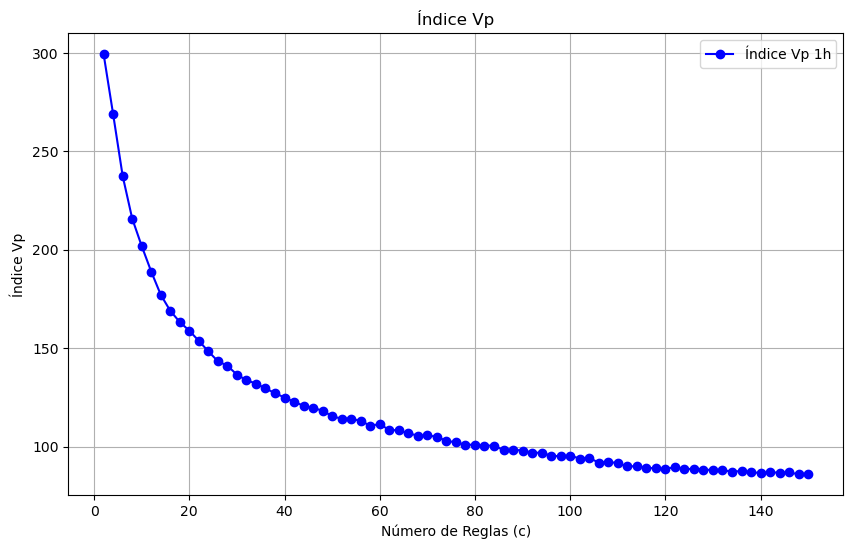

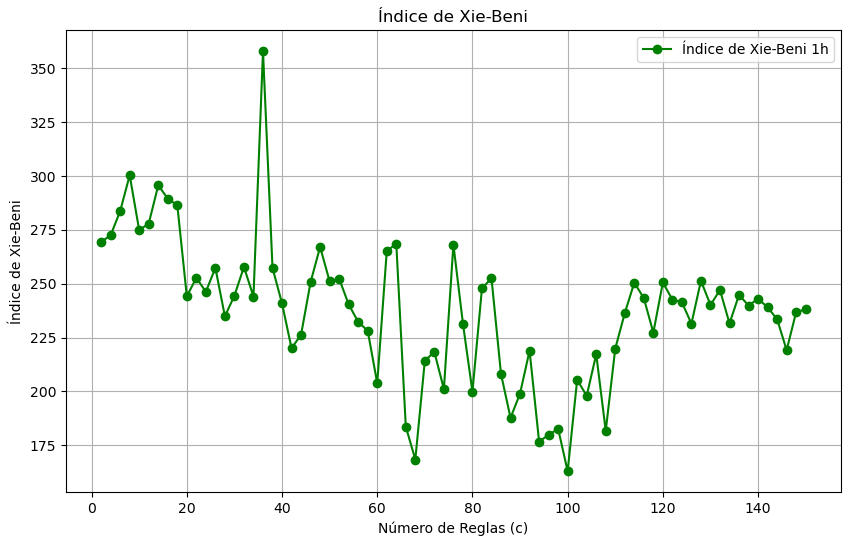

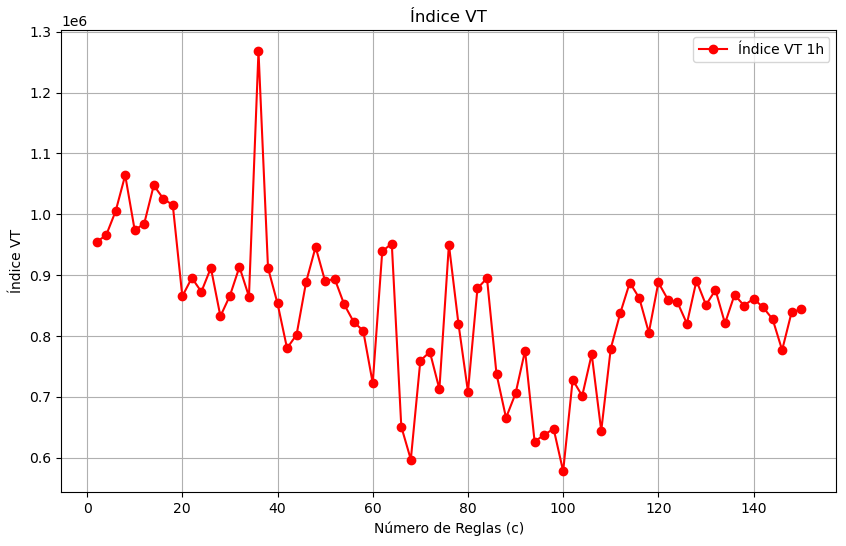

In [54]:
from scipy.spatial import distance

# Determinar el número óptimo de reglas mediante Fuzzy C-Means (FCM)
c_values = range(2,151,2)  
VP_indices = []
XB_indices = []
VT_indices = []

# Definir la función para calcular el XB index
def calculate_XB_index(c, X, m, cntr, u):
    n = X.shape[1]  # Número de datos en train
    XB_index = 0
    VT_index = 0
    
    for i in range(c):
        for j in range(n):
            dist = distance.euclidean(X[:, j], cntr[i])
            XB_index += (u[i, j] ** m) * dist ** 2
            VT_index += (u[i, j] ** m) * dist ** 2

    dif_centr = 0
    for i in range(c):
        for k in range(c):
            if k!=i:
                dif_centr+= distance.euclidean(cntr[i], cntr[k])
    VT_index += (1/(c*(c+1))) * dif_centr
    
    min_distance = np.inf
    for i in range(c):
        for j in range(i+1, c):
            dist = distance.euclidean(cntr[i], cntr[j])
            if dist < min_distance:
                min_distance = dist
    
    VT_index = VT_index / (min_distance + (1/c))
    XB_index = XB_index / (n * min_distance)
    return XB_index, VT_index

mejor_VT = float('inf')

for c in c_values:
    cntr, u, _, _, _, _, _ = cmeans(X, c, m, error=0.005, maxiter=1000, init=None)
    # Calcular el índice de validez Vp
    sum_max_membership = np.sum(np.max(u, axis=0))
    # Calcular sum_min_membership
    sum_min_membership = 0
    for i in range(c):
        for j in range(i + 1, c):
            min_membership_ij = np.sum(np.minimum(u[i, :], u[j, :]))  / len(X)
            sum_min_membership += min_membership_ij

    K = sum(range(1, c))
    Vp = (1 / len(X)) * sum_max_membership - (1 / K) * sum_min_membership
    VP_indices.append(Vp)

    XB_index, VT_index = calculate_XB_index(c, X, m, cntr, u)
    XB_indices.append(XB_index)
    VT_indices.append(VT_index)
    if VT_index < mejor_VT:
        mejor_VT = VT_index
        mejor_cntr = cntr
        mejor_u = u
        mejor_c = c
    
import matplotlib.pyplot as plt

# Gráfico para Índice Vp
plt.figure(figsize=(10, 6))
plt.plot(c_values, VP_indices, marker='o', label='Índice Vp 1h', color='blue')
plt.xlabel('Número de Reglas (c)')
plt.ylabel('Índice Vp')
plt.title('Índice Vp')
plt.grid(True)
plt.legend()
plt.savefig('indice_vp41.png', dpi=300)  # Guardar como PNG
# plt.savefig('indice_vp.jpg', dpi=300)  # Guardar como JPG
plt.show()

# Gráfico para Índice de Xie-Beni
plt.figure(figsize=(10, 6))
plt.plot(c_values, XB_indices, marker='o', label='Índice de Xie-Beni 1h', color='green')
plt.xlabel('Número de Reglas (c)')
plt.ylabel('Índice de Xie-Beni')
plt.title('Índice de Xie-Beni')
plt.grid(True)
plt.legend()
plt.savefig('indice_xb41.png', dpi=300)  # Guardar como PNG
# plt.savefig('indice_xb.jpg', dpi=300)  # Guardar como JPG
plt.show()

# Gráfico para Índice VT
plt.figure(figsize=(10, 6))
plt.plot(c_values, VT_indices, marker='o', label='Índice VT 1h', color='red')
plt.xlabel('Número de Reglas (c)')
plt.ylabel('Índice VT')
plt.title('Índice VT')
plt.grid(True)
plt.legend()
plt.savefig('indice_vt41.png', dpi=300)  # Guardar como PNG
# plt.savefig('indice_vt.jpg', dpi=300)  # Guardar como JPG
plt.show()


In [55]:
print(mejor_c)

100


In [56]:
min_VT_index = np.min(VT_indices)
index_min_VT_index = np.argmin(VT_indices)
c_for_min_VT_index = c_values[index_min_VT_index]
print("Valor mínimo dentro de VT_indices:", min_VT_index)
print("Valor de c correspondiente al mínimo valor de XB_indices:", c_for_min_VT_index)

Valor mínimo dentro de VT_indices: 577596.5987183703
Valor de c correspondiente al mínimo valor de XB_indices: 100


In [57]:
# Obtener los centroides de los clústeres
centroides = pd.DataFrame(mejor_cntr, columns=new_df.columns)

print(centroides)

          T_1        V_1          P_1        T_2        V_2          P_2  \
0   12.113240   7.148429  1376.236312  12.068432   7.074965  1243.765681   
1   11.197696   4.546231   288.634843  11.428855   4.643902   309.633407   
2   12.843933  12.417200  4127.405382  13.093648  12.117617  4139.555757   
3   14.494742   7.669752  1684.542214  14.460067   8.055492  1939.725480   
4   12.156087   8.490176  2480.625504  11.480267   8.831262  2620.542592   
..        ...        ...          ...        ...        ...          ...   
95  11.750575   5.365540   476.927419  12.038195   5.252915   439.906732   
96  14.116504   7.339109  1455.579591  13.974589   7.089341  1286.169770   
97  12.468986   3.568879    77.108332  12.603840   3.802115   112.423495   
98  13.527314  13.529868  4160.301496  13.522711  13.637813  4159.646110   
99  12.231382  13.070408  4136.549473  12.295267  12.676462  4133.078619   

          T_3        V_3          P_3         P_30  
0   12.026654   6.999518  1234.133

### Inferencia del modelo y selección de hiperparámetros mediante algoritmo genético

In [58]:
import numpy as np

def gaussian_mf(x, center, sigma):
    return np.exp(-((x - center) ** 2) / (sigma ** 2))

def predict_output(data, centroids, sigmas, z_values):
    num_rules = centroids.shape[0]
    num_data = data.shape[0]
    num_inputs = centroids.shape[1]
    
    outputs = np.zeros(num_data)
    
    for i in range(num_data):
        rule_outputs = np.zeros(num_rules)
        rule_denominators = np.zeros(num_rules)
        for j in range(num_rules):
            rule_membership = 1
            for k in range(num_inputs):
                rule_membership *= gaussian_mf(data[i, k], centroids[j, k], sigmas[j, k])
            rule_outputs[j] = z_values[j] * rule_membership
            rule_denominators[j] = rule_membership
        # Verificar si hay divisiones por cero
        if np.sum(rule_denominators) != 0:
            outputs[i] = np.sum(rule_outputs) / np.sum(rule_denominators)
        else:
            # Si todos los denominadores son cero, asignar NaN a la salida
            outputs[i] = np.nan
    
    return outputs

def root_mean_squared_error(true_values, predicted_values):
    # Verificar si hay algún valor NaN en las predicciones
    if np.isnan(predicted_values).any():
        return np.inf
    else:
        # Calcular el error cuadrático medio, ignorando los valores NaN
        mse = np.nanmean((true_values - predicted_values) ** 2)
        # Calcular la raíz cuadrada del error cuadrático medio
        rmse = np.sqrt(mse)
        return rmse

def optimize_sigmas(data, targets, centroids, z_values, initial_sigmas):
    def loss_function(sigmas):
        predicted_values = predict_output(data, centroids, sigmas.reshape(centroids.shape), z_values)
        return root_mean_squared_error(targets, predicted_values)
    
    from scipy.optimize import minimize
    result = minimize(loss_function, initial_sigmas.flatten(), method='Nelder-Mead')
    optimized_sigmas = result.x.reshape(centroids.shape)
    
    return optimized_sigmas

In [59]:
# Suponiendo que tenemos los datos, las salidas reales, los centroides de los clústeres, y los valores de z predefinidos
data = train_data.iloc[:, :-1].values
targets = train_data.iloc[:, -1].values
centroids = centroides.iloc[:, :-1].values
z_values = centroides.iloc[:, -1].values

In [44]:
pip install pymoo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Calcular la desviación estándar de cada columna
std_col1 = np.std(data[:, 0])
std_col2 = np.std(data[:, 1])
std_col3 = np.std(data[:, 2])

print("Desviaciones estándar de viento, temperatura y potencia")
print(std_col1,std_col2,std_col3)

In [60]:
# Crear una matriz de unos con las dimensiones requeridas
lower_sigmas = np.ones((mejor_c, 9))

# Definir los valores de los límites superiores e inferiores
lower_bounds = np.array([1, 1, 500])  # Valores inferiores
upper_bounds = np.array([6, 6, 2000])  # Valores superiores

# Asignar los valores deseados a las columnas específicas
lower_sigmas[:, [0, 3, 6]] *= lower_bounds[0]
lower_sigmas[:, [1, 4, 7]] *= lower_bounds[1]
lower_sigmas[:, [2, 5, 8]] *= lower_bounds[2]

# Crear una matriz de unos para los límites superiores
upper_sigmas = np.ones((mejor_c, 9))

# Asignar los valores deseados a las columnas específicas para los límites superiores
upper_sigmas[:, [0, 3, 6]] *= upper_bounds[0]
upper_sigmas[:, [1, 4, 7]] *= upper_bounds[1]
upper_sigmas[:, [2, 5, 8]] *= upper_bounds[2]

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

# Definir la función objetivo
class RMSEOptimization(Problem):
    def __init__(self, centroids, z_values, true_values, data):
        super().__init__(n_var=lower_sigmas.size, n_obj=1, n_constr=0, xl=lower_sigmas.flatten(), xu=upper_sigmas.flatten())
        self.centroids = centroids
        self.z_values = z_values
        self.true_values = true_values
        self.data = data
    
    def _evaluate(self, x, out, *args, **kwargs):
        
        # Obtener el número de individuos en la población
        n_individuals = x.shape[0]
    
        # Inicializar la matriz de salida F con ceros
        out["F"] = np.zeros((n_individuals, self.n_obj))
    
        for i in range(n_individuals):
            # Obtener la matriz de sigmas del individuo actual
            sigmas = x[i].reshape(self.centroids.shape)
        
            # Calcular las predicciones utilizando la función predict_output
            predicted_values = predict_output(self.data, self.centroids, sigmas, self.z_values)
        
            # Calcular la función de ajuste (en este caso, el error cuadrático medio)
            fit = root_mean_squared_error(self.true_values, predicted_values)
        
            # Asignar el valor de ajuste al individuo actual en la matriz de salida F
            out["F"][i, 0] = fit

# Definir los datos y valores iniciales
data = train_data.iloc[:, :-1].values
targets = train_data.iloc[:, -1].values
centroids = centroides.iloc[:, :-1].values
z_values = centroides.iloc[:, -1].values

# Definir el problema de optimización
problem = RMSEOptimization(centroids, z_values, targets, data)

# Definir el algoritmo genético
algorithm = GA(pop_size=50)

# Ejecutar la optimización
res = minimize(problem, algorithm, ("n_gen", 75), seed=1, verbose=True)

# Obtener los sigmas óptimos
optimal_sigmas = res.X.reshape(centroids.shape)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |  5.258953E+02 |  5.079711E+02
     2 |      100 |  5.179675E+02 |  5.079711E+02
     3 |      150 |  5.137651E+02 |  5.053887E+02
     4 |      200 |  5.109387E+02 |  5.053887E+02
     5 |      250 |  5.089362E+02 |  4.998166E+02
     6 |      300 |  5.064190E+02 |  4.990382E+02
     7 |      350 |  5.042806E+02 |  4.990382E+02
     8 |      400 |  5.027027E+02 |  4.980825E+02
     9 |      450 |  5.010419E+02 |  4.970091E+02
    10 |      500 |  4.999658E+02 |  4.956714E+02
    11 |      550 |  4.989767E+02 |  4.956714E+02
    12 |      600 |  4.979129E+02 |  4.956714E+02
    13 |      650 |  4.967344E+02 |  4.925680E+02
    14 |      700 |  4.958052E+02 |  4.925680E+02
    15 |      750 |  4.949130E+02 |  4.912533E+02
    16 |      800 |  4.934578E+02 |  4.895167E+02
    17 |      850 |  4.919344E+02 |  4.888846E+02
    18 |      900 |  4.908635E+02 |  4.873972E+02
    19 |      950 |  4.898366E+02 |  4.867070E+02


In [24]:
print(optimal_sigmas)

[[4.33475481e+00 3.14736983e+00 1.75535393e+03 4.25603495e+00
  1.10225266e+00 1.35683372e+03 2.55840336e+00 2.16340572e+00
  5.50660809e+02]
 [1.35147854e+00 2.91616259e+00 1.69581634e+03 4.77091333e+00
  1.57306531e+00 8.59118119e+02 1.76992884e+00 3.95975734e+00
  5.28479270e+02]
 [1.05128904e+00 1.25337191e+00 1.55941135e+03 1.68897142e+00
  3.72671426e+00 1.14728887e+03 1.24168536e+00 4.46760632e+00
  1.60350233e+03]
 [1.19970495e+00 1.41842716e+00 1.12801944e+03 5.27842926e+00
  3.60610285e+00 5.77972417e+02 1.01910473e+00 1.54050416e+00
  5.11835057e+02]
 [5.70824824e+00 1.05296253e+00 8.47908491e+02 4.93430825e+00
  4.29044249e+00 6.06890831e+02 4.13809869e+00 1.01159011e+00
  1.06838685e+03]
 [5.63640263e+00 5.31375789e+00 1.46231272e+03 4.38761180e+00
  4.95032797e+00 1.39546737e+03 5.72959221e+00 4.44634495e+00
  6.35154129e+02]
 [4.05781205e+00 2.53100916e+00 1.30239092e+03 5.02016685e+00
  2.47284357e+00 1.58125561e+03 4.05361278e+00 1.24499119e+00
  5.82315798e+02]
 [3.17

### Entrenamiento modelo final y evaluación en el test

In [ ]:
# Entrenar el modelo final con los datos de entrenamiento
final_model_predictions_train = predict_output(data, centroids, optimal_sigmas, z_values)
print(final_model_predictions_train)

# Calcular el error cuadrático medio real para el conjunto de entrenamiento
mse_train = root_mean_squared_error(targets, final_model_predictions_train)
print("Error cuadrático medio para el conjunto de entrenamiento:", mse_train)

# Predecir para el conjunto de prueba usando el modelo final entrenado
test = test_data.iloc[:, :-1].values
final_model_predictions_test = predict_output(test, centroids, optimal_sigmas,z_values)

# Desnormalizar los objetivos del conjunto de prueba
test_targets = test_data.iloc[:, -1].values

# Calcular el error cuadrático medio real para el conjunto de prueba
mse_test = root_mean_squared_error(test_targets, final_model_predictions_test)
print("Error cuadrático medio para el conjunto de prueba:", mse_test)

In [ ]:
# Crear una secuencia para el eje x
x_sequence = range(len(targets))

# Graficar los valores reales y los predichos
plt.figure(figsize=(10, 6))
plt.plot(x_sequence, targets, label='Valores Reales', marker='o', color='blue', markersize=3)  # Ajusta el tamaño de los puntos
plt.plot(x_sequence, final_model_predictions_train, label='Valores Predichos', marker='x', color='red', markersize=3)  # Ajusta el tamaño de los puntos
plt.xlabel('Secuencia')
plt.ylabel('Valor')
plt.title('Valores Reales vs. Valores Predichos (Train)')
plt.legend()
plt.grid(True)

# Guardar la imagen en formato PNG
plt.savefig('valores_predichos_train41.png', dpi=300)  # Ajusta la resolución según sea necesario
# También puedes guardar en formato JPG
# plt.savefig('valores_predichos.jpg', dpi=300)

plt.show()


In [ ]:
# Crear una secuencia para el eje x
x_sequence_test = range(len(test_targets))

# Graficar los valores reales y los predichos para el conjunto de prueba
plt.figure(figsize=(10, 6))
plt.plot(x_sequence_test, test_targets, label='Valores Reales (Test)', marker='o', color='blue', markersize=3)  # Ajusta el tamaño de los puntos
plt.plot(x_sequence_test, final_model_predictions_test, label='Valores Predichos (Test)', marker='x', color='red', markersize=3)  # Ajusta el tamaño de los puntos
plt.xlabel('Secuencia')
plt.ylabel('Valor')
plt.title('Valores Reales vs. Valores Predichos (Test)')
plt.legend()
plt.grid(True)

# Guardar la imagen en formato PNG
plt.savefig('valores_predichos_test41.png', dpi=300)  # Ajusta la resolución según sea necesario
# También puedes guardar en formato JPG
# plt.savefig('valores_predichos_test.jpg', dpi=300)

plt.show()